In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
import keyboard

# Actor Network
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU()
        )
        self.mu = nn.Sequential(
            nn.Linear(256, action_dim),
            nn.Tanh() # 输出范围在[-1, 1]之间
        )
        self.std = nn.Sequential(
            nn.Linear(256, action_dim), # 不同状态可以有不同的标准差
            nn.Tanh()  
        )
        #self.global_log_std = nn.Parameter(torch.zeros(action_dim))  # 全局偏移量

    def forward(self, state):
        x = self.fc(state)
        mean = self.mu(x) * 2  # 范围在[-2, 2]之间
        std = self.std(x) * 2 + 2.0001  # 范围在[0.0001, 4.0001]之间
        return mean, std

# Critic Network
class CriticNetwork(nn.Module):
    def __init__(self, state_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

# Function to select action based on policy
def select_action(actor, state):
    with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32)
        mean, std = actor(state)
        dist = torch.distributions.Normal(mean, std)
        # 重采样，直到动作在范围内
        while True:
            action = dist.sample()
            if -2.0 <= action <= 2.0:
                break
        # 修正动作概率
        cdf_min = dist.cdf(torch.tensor(-2.0, dtype=torch.float32))
        cdf_max = dist.cdf(torch.tensor(2.0, dtype=torch.float32))
        normalization_constant = (cdf_max - cdf_min).clamp(min=1e-6)  # 避免数值问题
        log_prob = (dist.log_prob(action) - torch.log(normalization_constant)).sum()
        return action.numpy(), log_prob

def select_action_clamp(actor, state):
    with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32)
        mean, std = actor(state)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()#.clamp(-2.0, 2.0)  # 限制动作范围在[-2, 2]之间
        # 修正概率
        log_prob = dist.log_prob(action)
        cdf_min = dist.cdf(torch.tensor(-2.0, dtype=torch.float32))
        cdf_max = dist.cdf(torch.tensor(2.0, dtype=torch.float32))
        if action <= -2.0:
            log_prob = torch.log(cdf_min)
            action = torch.tensor(-2.0)
        elif action >= 2.0:
            log_prob = torch.log(1.0 - cdf_max)
            action = torch.tensor(2.0)
        return action.numpy(), log_prob.sum()

# 贪心策略选择动作
def select_greedy_action(actor, state):
    with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32)
        mean, _ = actor(state)
        return mean.detach().numpy()

class MultiStepPrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, n_step=3, gamma=0.99):
        """
        capacity: 缓冲区容量
        alpha: 优先级比例，0表示完全随机采样，1表示完全按优先级采样
        n_step: 多步时间跨度
        gamma: 折扣因子
        """
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.alpha = alpha
        self.n_step = n_step
        self.gamma = gamma
        self.gammas = np.array([gamma ** i for i in range(n_step + 1)], dtype=np.float32)

        # 用于多步存储的临时队列
        self.n_step_queue = []

    def _get_n_step_info(self):
        """从 n_step_queue 计算 n 步累计奖励和目标状态"""
        R = 0
        # 实际队列长度可能小于 n_step
        n_step = len(self.n_step_queue)
        for idx, (_, _, _, reward, _, _) in enumerate(self.n_step_queue):
            R += self.gammas[idx] * reward
        state, action, action_prob, _, next_state, done = self.n_step_queue[0]
        final_next_state, final_done = self.n_step_queue[-1][4], self.n_step_queue[-1][5]
        return (state, action, action_prob, R, final_next_state, final_done, n_step)

    def add(self, state, action, action_prob, reward, next_state, done):
        """
        添加新经验。
        使用 n_step_queue 缓存多步数据，只有在积累到 n 步时才存入 buffer。
        在轨迹结束时处理剩余的队列。
        """
        self.n_step_queue.append((state, action, action_prob, reward, next_state, done))
        
        # 如果 n_step_queue 满了，处理一个完整的 n-step 转移
        if len(self.n_step_queue) == self.n_step:
            n_step_transition = self._get_n_step_info()
            max_priority = self.priorities.max() if self.buffer else 1.0
            if len(self.buffer) < self.capacity:
                self.buffer.append(n_step_transition)
            else:
                self.buffer[self.position] = n_step_transition
            self.priorities[self.position] = max_priority
            self.position = (self.position + 1) % self.capacity

            # 移除队列的第一个元素
            self.n_step_queue.pop(0)

        # 如果 done=True，处理剩余队列中的短步转移
        if done:
            while self.n_step_queue:
                n_step_transition = self._get_n_step_info()
                max_priority = self.priorities.max() if self.buffer else 1.0
                if len(self.buffer) < self.capacity:
                    self.buffer.append(n_step_transition)
                else:
                    self.buffer[self.position] = n_step_transition
                self.priorities[self.position] = max_priority
                self.position = (self.position + 1) % self.capacity

                # 移除队列的第一个元素
                self.n_step_queue.pop(0)

    def sample(self, batch_size, beta=0.4, device='cpu'):
        """
        采样带优先级的批次数据。
        """
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]

        # 根据优先级分布计算采样概率
        probs = priorities ** self.alpha
        probs /= (probs.sum() + 1e-8)

        # 按照概率采样
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # 计算重要性采样权重
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        # 解包样本
        states, actions, action_probs, rewards, next_states, dones, n_steps = zip(*samples)
        return (
            torch.tensor(np.stack(states), dtype=torch.float32).to(device),
            torch.tensor(np.array(actions, dtype=np.float32), dtype=torch.float32).to(device),
            torch.tensor(np.array(action_probs, dtype=np.float32), dtype=torch.float32).to(device),
            torch.tensor(rewards, dtype=torch.float32).to(device),
            torch.tensor(np.stack(next_states), dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).to(device),
            torch.tensor(weights, dtype=torch.float32).to(device),
            torch.tensor(n_steps, dtype=torch.int64).to(device),
            indices,
        )

    def update_priorities(self, indices, priorities):
        """根据新的 TD Error 更新优先级"""
        self.priorities[indices] = priorities

    def size(self):
        return len(self.buffer)
    
    def current_queue_size(self):
        return len(self.n_step_queue)
    
def train_actor_critic(env_name="Pendulum-v1", 
                       actor_lr=3e-4, 
                       critic_lr=3e-4, 
                       gamma=0.99, 
                       max_episodes=1000, 
                       max_timesteps=500, 
                       success_episodes=5,
                       waveformGraph=False,
                       outputLog=False,
                       n_steps=5,
                       lambda_=0.95,
                       alpha=0.6,
                       replay_buffer_capacity=100000,
                       batch_size=256,
                       beta=0.4, 
                       beta_increment=1e-4):
    # Initialize environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    print(f"Environment: {env_name}")
    print(f"State space: {state_dim} dimensions")
    print(f"Action space: {action_dim} actions")
    print(f"Reward threshold: {env.spec.reward_threshold}")
    print(f"Maximum episode steps: {env.spec.max_episode_steps}")

    # Initialize networks and optimizers
    actor = ActorNetwork(state_dim, action_dim)
    critic = CriticNetwork(state_dim)
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)

    replay_buffer = MultiStepPrioritizedReplayBuffer(capacity=replay_buffer_capacity, alpha=alpha, n_step=n_steps, gamma=gamma)

    # Training loop
    success_count = 0
    success_count2 = 0
    total_rewards = []
    last_step_rewards = []
    epsilon = 0.9

    if waveformGraph:
        plt.ion()
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        line1, = ax1.plot([], [], label='Total Reward', color='tab:blue')
        ax1.legend()

        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Last Step Reward')
        line2, = ax2.plot([], [], label='Last Step Reward', color='tab:orange')
        ax2.legend()

    # Parameters for truncated TD(λ)
    weight = 1 - lambda_
    lambdas = [lambda_ ** i for i in range(n_steps + 1)]
    # 对lambdas进行归一化
    #weights = [l / sum(lambdas) for l in lambdas]
    #print(f"weights: ", weights)
    #print(f"weights: ", [weight * lambdas[i] if i + 1 < n_steps else weight * lambdas[i] + lambdas[i + 1] for i in range(n_steps)])
    gammas = torch.tensor([gamma ** i for i in range(n_steps + 1)])

    for episode in range(max_episodes):
        state = env.reset()
        state = state[0]
        total_reward = 0
        done = False
        bExit = False
        
        '''states = []
        rewards = []
        actions = []'''
        t = 0

        while not done:
            #if done == False:
            # Select action and observe reward and next state
            action, action_prob = select_action(actor, state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            '''cos_value = next_state[0]
            sin_value = next_state[1]
            angle = np.arctan2(sin_value, cos_value)
            # 将角度值转换到0到2*pi之间
            if angle < 0:
                angle += 2 * np.pi
            # 将角度值映射到pi到-pi之间的奖励值
            reward = -angle + np.pi'''

            # Store state and reward
            '''states.append(state)
            rewards.append(reward * 0.001)  # Scale reward
            actions.append(action)'''

            replay_buffer.add(state, action, action_prob, reward, next_state, done)

            # Transition to the next state
            state = next_state
            total_reward += reward

            if done:
                last_step_rewards.append(reward)
            
            # 按下ESC键退出训练
            if keyboard.is_pressed('esc'):
                bExit = True

            # 经验回放训练
            if replay_buffer.size() >= batch_size:
                # 从优先级缓冲区中采样
                states, actions, old_action_probs, rewards, next_states, dones, weights, n_step_batch, indices = replay_buffer.sample(batch_size, beta)
                # 批量计算 action_probs
                means, stds = actor(states)
                action_probs = torch.distributions.Normal(means, stds).log_prob(actions).sum(dim=1)
                # 策略重要性修正权重
                weights_policy = torch.exp(action_probs - old_action_probs)
                weights_policy = torch.min(weights_policy, torch.tensor(1.5))  # 防止权重过大
                # 批量计算 values和 next_values
                values = critic(states).squeeze()
                next_values = critic(next_states).squeeze()
                # 计算 G_ns
                G_ns = rewards + gammas[n_step_batch] * next_values
                td_errors = G_ns - values
                #all_states = states + [next_state]
                '''all_states_np = np.array([states[0], next_state])
                all_states_tensor = torch.tensor(all_states_np, dtype=torch.float32)
                values = critic(all_states_tensor).squeeze()'''
                #G_ns = []
                '''R = torch.tensor(0, dtype=torch.float32)
                reward_tensor = torch.tensor(rewards, dtype=torch.float32)
                for n in range(len(rewards)):
                    R += gammas[n] * reward_tensor[n]'''
                '''if n == len(rewards) - 1:
                        G_ns.append(R + gammas[n + 1] * values[n + 1] * (1 - int(terminated)))
                    else:
                        G_ns.append(R + gammas[n + 1] * values[n + 1])'''
                #G_n = R + gammas[len(rewards)] * values[-1] * (1 - int(terminated))
                #G_lambda = sum([lambdas[i] * G_ns[i] for i in range(len(rewards))]) * weight + G_ns[-1] * lambdas[len(rewards)]

                # Calculate TD Error
                #td_error = G_n - values[0]
                #td_errors = torch.tensor(G_ns, dtype=torch.float32) - values[0]
                #weights_current_tensor = torch.tensor(weights_current, dtype=torch.float32)

                # Update Actor (Policy Gradient)
                actor_loss = -torch.mean(action_probs * td_errors.detach() * weights)
                #actor_loss = -torch.dot(torch.log(action_probs), td_errors.detach() * weights_current_tensor)
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Update Critic (Value Loss)
                critic_loss = (td_errors.pow(2) * weights).mean()
                #critic_loss = torch.sum(td_errors ** 2 * weights_current_tensor)
                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                # 更新优先级
                priorities = td_errors.abs().detach().cpu().numpy() + 1e-6
                replay_buffer.update_priorities(indices, priorities)

                # 更新 beta
                beta = min(1.0, beta + beta_increment)

                '''states.pop(0)
                rewards.pop(0)
                actions.pop(0)

            t += 1
            if states == [] and (done or t >= max_timesteps):
                break'''

        total_rewards.append(total_reward)
        if waveformGraph:
            # 更新Total Reward子图
            line1.set_data(range(len(total_rewards)), total_rewards)
            ax1.relim()
            ax1.autoscale_view()

            # 更新Last Step Reward子图
            line2.set_data(range(len(last_step_rewards)), last_step_rewards)
            ax2.relim()
            ax2.autoscale_view()

            plt.pause(0.025)

        if outputLog and (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        # Check for success
        #if env.spec.reward_threshold is not None:
        if total_reward >= -400:
            success_count += 1
            if last_step_rewards[-1] >= -0.02:
                success_count2 += 1
            else:
                success_count2 = 0
            current_actor_lr = actor_optimizer.param_groups[0]['lr']
            current_critic_lr = critic_optimizer.param_groups[0]['lr']
            if success_count >= success_episodes and success_count2 % 10 == 0: # 降低学习率
                actor_optimizer.param_groups[0]['lr'] = max(current_actor_lr * 0.1, actor_lr * 0.001)
                critic_optimizer.param_groups[0]['lr'] = max(current_critic_lr * 0.1, critic_lr * 0.001)
                print(f"Lowered learning rate to {current_actor_lr * 0.1} at episode {episode + 1}")
            '''if success_count >= success_episodes:
                print(f"Solved after {success_count} consecutive successful episodes! Total episodes: {episode + 1}")
                if success_count % 10 == 0:
                    # 保存模型： 环境名_actor+时间.pth 和 环境名_critic+时间.pth
                    torch.save(actor.state_dict(), env_name + '_actor' + '_' + str(datetime.now().strftime("%Y%m%d_%H%M%S")) + '.pth')
                    torch.save(critic.state_dict(), env_name + '_critic' + '_' + str(datetime.now().strftime("%Y%m%d_%H%M%S")) + '.pth')
                if success_count2 >= 10:
                    print(f"Last step reward >= -0.02 for 10 consecutive episodes! Total episodes: {episode + 1}")
                    break'''
            if success_count >= success_episodes * 1.5 and success_count2 >= success_episodes * 1.5:
                print(f"Success count >= {success_episodes * 1.5}, break!")
                break
            if success_count2 >= success_episodes and success_count2 % 10 == 0: # 每10次连续成功保存一次模型
                # 保存模型： 环境名_actor+时间.pth 和 环境名_critic+时间.pth
                torch.save(actor.state_dict(), env_name + '_actor' + '_' + str(datetime.now().strftime("%Y%m%d_%H%M%S")) + '.pth')
                torch.save(critic.state_dict(), env_name + '_critic' + '_' + str(datetime.now().strftime("%Y%m%d_%H%M%S")) + '.pth')
        else:
            success_count = 0
            success_count2 = 0
            # 升高学习率
            actor_optimizer.param_groups[0]['lr'] = actor_lr
            critic_optimizer.param_groups[0]['lr'] = critic_lr
        
        if bExit:
            print(f"按下ESC键，退出训练！")
            break

    plt.ioff()
    #plt.show()
    plt.close()
    # 保存模型
    torch.save(actor.state_dict(), env_name + '_actor.pth')
    torch.save(critic.state_dict(), env_name + '_critic.pth')

    return actor, critic, total_rewards, last_step_rewards

Environment: Pendulum-v1
State space: 3 dimensions
Action space: 1 actions
Reward threshold: None
Maximum episode steps: 200


c:\Users\Windows11\anaconda3\envs\py310_torch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Lowered learning rate to 1e-05 at episode 3730
Lowered learning rate to 1.0000000000000002e-06 at episode 3740
Lowered learning rate to 1.0000000000000002e-07 at episode 3750
Lowered learning rate to 1.0000000000000004e-08 at episode 3760
Lowered learning rate to 1.0000000000000002e-08 at episode 3770
Lowered learning rate to 1.0000000000000002e-08 at episode 3780
Success count >= 150.0, break!


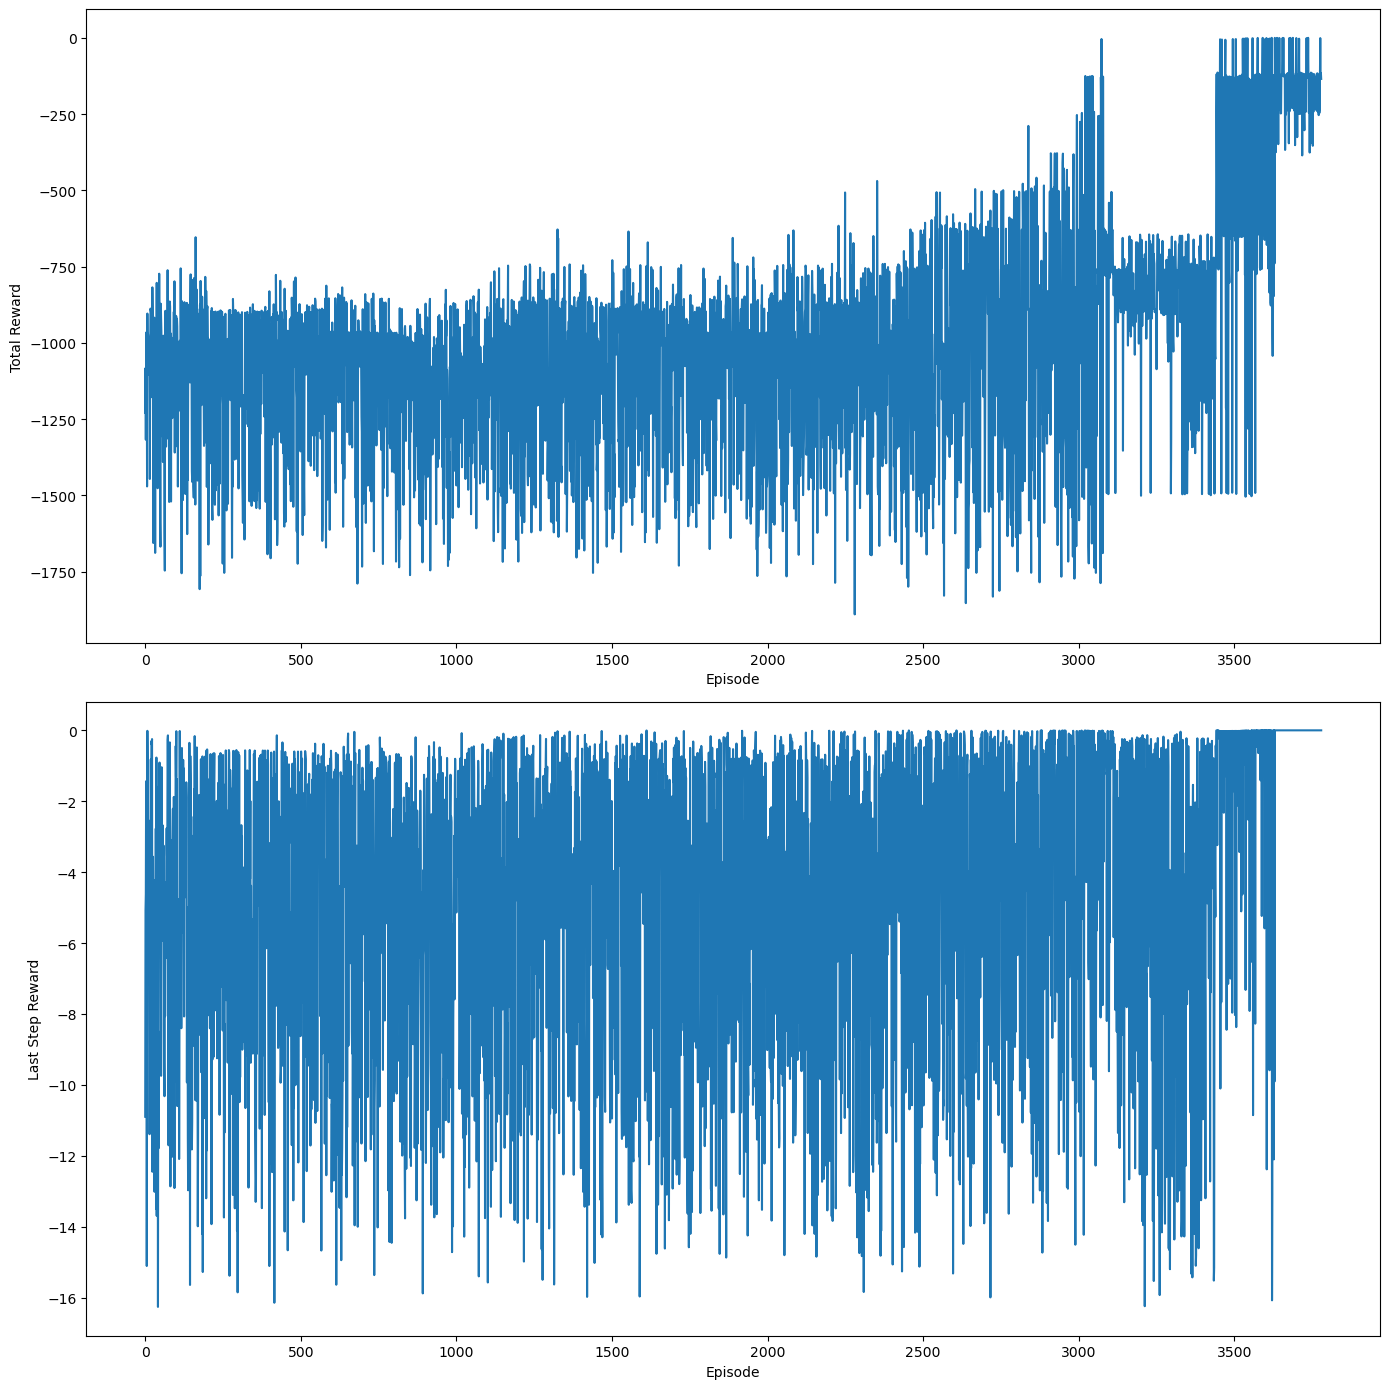

In [2]:
# 在新窗口中显示图像
%matplotlib qt
actor_net, critic_net, total_rewards, last_step_rewards = train_actor_critic(env_name="Pendulum-v1", 
                    actor_lr=1e-4, 
                    critic_lr=1e-3, 
                    gamma=0.99, 
                    max_episodes=50000, 
                    max_timesteps=1000, 
                    success_episodes=100,
                    waveformGraph=True,
                    outputLog=False,
                    n_steps=3,
                    lambda_=1,
                    alpha=0.6,
                    replay_buffer_capacity=100000,
                    batch_size=512,
                    beta=0.4, 
                    beta_increment=1e-4)
# 重新设置为行内显示
%matplotlib inline
# 调整图像大小
plt.figure(figsize=(14, 14))
# 绘制总奖励曲线
plt.subplot(2, 1, 1)
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# 绘制最后一步奖励曲线
plt.subplot(2, 1, 2)
plt.plot(last_step_rewards)
plt.xlabel('Episode')
plt.ylabel('Last Step Reward')
# 调整布局并显示图像
plt.tight_layout()
plt.show()

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Environment: Pendulum-v1
State space: 3 dimensions
Action space: 1 actions
Reward threshold: None
Maximum episode steps: 200


c:\Users\Windows11\anaconda3\envs\py310_torch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Steps: 2000
Total Reward: 0


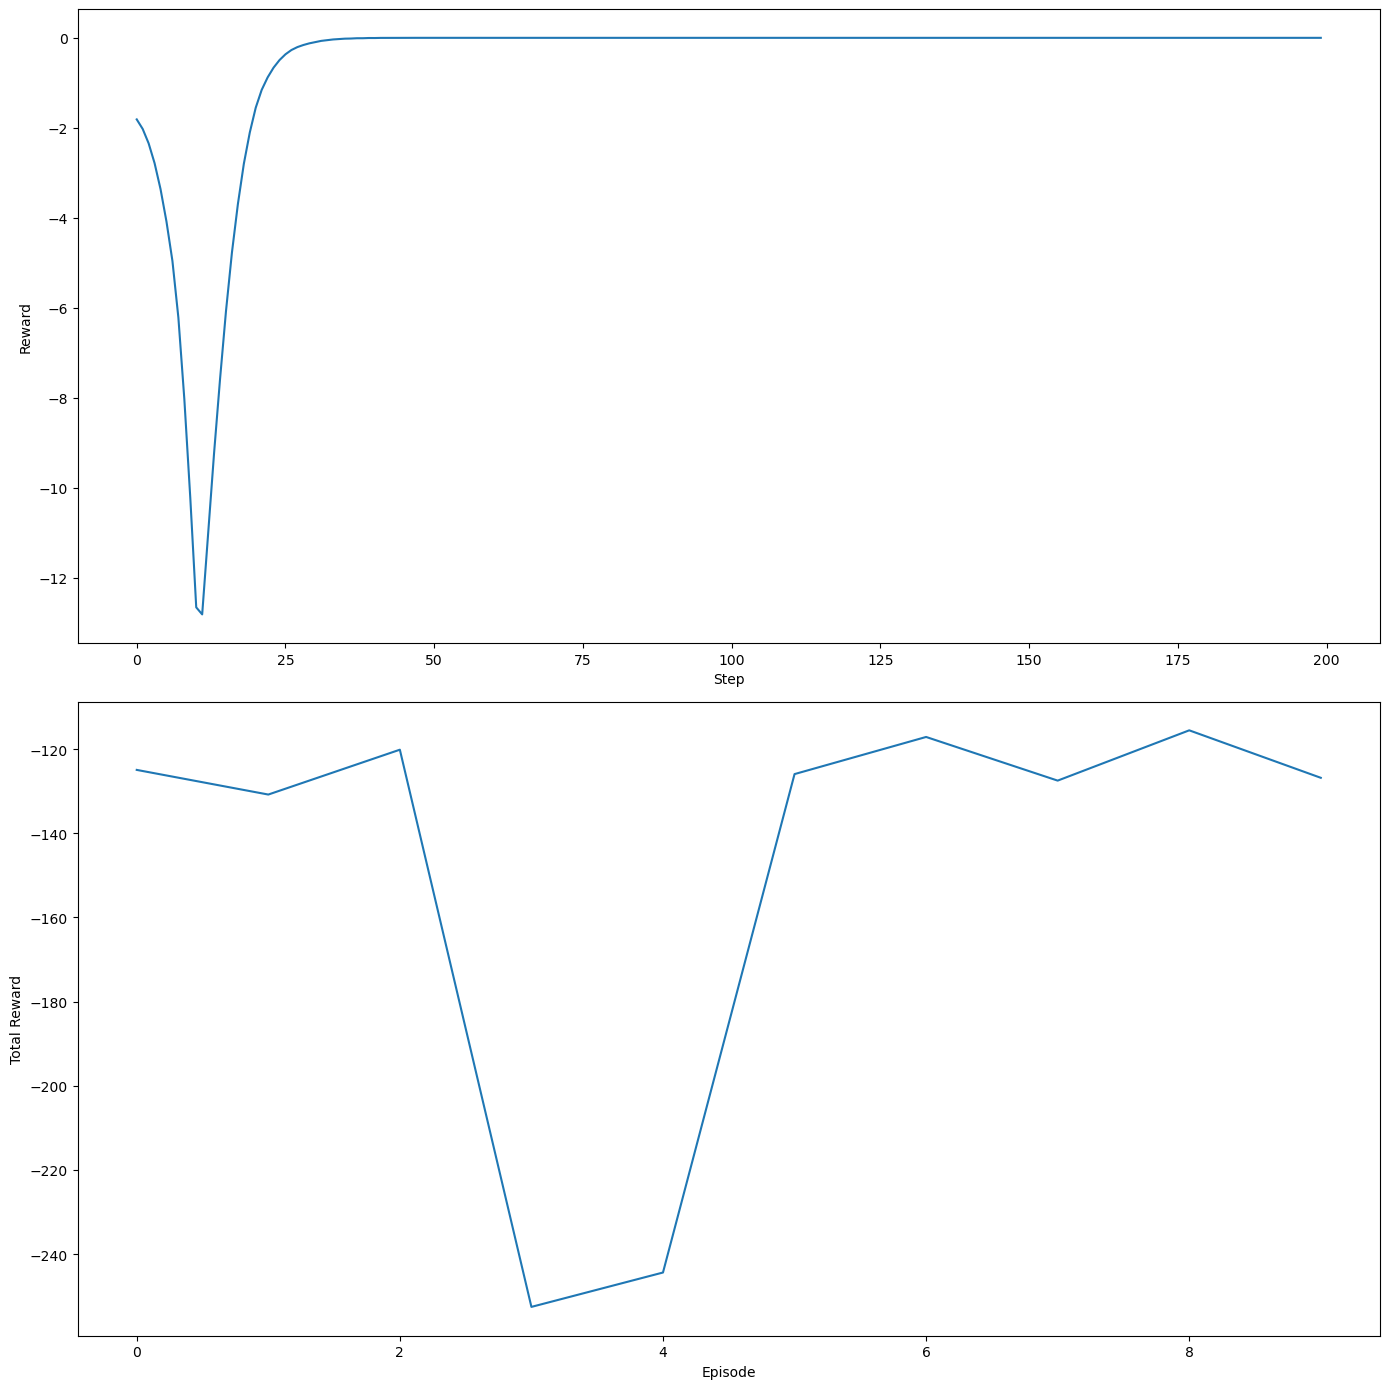

In [ ]:
import gym
import time
import pygame

# Test the trained model
def test_actor_critic(env_name="Pendulum-v1", max_episodes=10):
    
    # Initialize environment
    env = gym.make(env_name, render_mode="human") # render_mode="human"表示使用pygame进行渲染
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    print(f"Environment: {env_name}")
    print(f"State space: {state_dim} dimensions")
    print(f"Action space: {action_dim} actions")
    print(f"Reward threshold: {env.spec.reward_threshold}")
    print(f"Maximum episode steps: {env.spec.max_episode_steps}")

    # Initialize networks and optimizers
    actor_net = ActorNetwork(state_dim, action_dim)
    actor_net.load_state_dict(torch.load(env_name + '_actor.pth', weights_only=True)) # 加载训练好的actor网络
    actor_net.eval()
    state = env.reset()
    state = state[0]
    step = 0
    episode = 0
    bExit = False
    rewards = []
    rewards_history = []
    total_rewards = []

    while bExit == False and episode < max_episodes:
        #env.render()
        # 帧率控制
        #time.sleep(1/30)
        
        # 贪婪策略选择动作
        action = select_greedy_action(actor_net, state)
        state, reward, terminated, truncated, _ = env.step(action)
        step += 1
        rewards.append(reward)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                env.close()
                bExit = True
            # 按下esc键退出
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    env.close()
                    bExit = True
        if terminated or truncated:
            episode += 1
            total_rewards.append(sum(rewards))
            rewards_history.append(rewards)
            rewards = []
            state = env.reset()[0]

    env.close()
    print(f"Steps: {step}")
    #print(f"Total Reward: {sum(rewards)}")

    # 调整图像大小
    plt.figure(figsize=(14, 14))
    # 绘制奖励曲线
    plt.subplot(2, 1, 1)
    plt.plot(rewards_history[0])
    plt.xlabel('Step')
    plt.ylabel('Reward')

    # 绘制总奖励曲线
    plt.subplot(2, 1, 2)
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    # 调整布局并显示图像
    plt.tight_layout()
    plt.show()

    return total_rewards, rewards_history
%matplotlib inline
total_rewards, rewards_history = test_actor_critic(env_name="Pendulum-v1")

In [4]:
# 绘制奖励曲线
%matplotlib qt
plt.plot(rewards_history[1])
plt.xlabel('Step')
plt.ylabel('Reward')
plt.show()

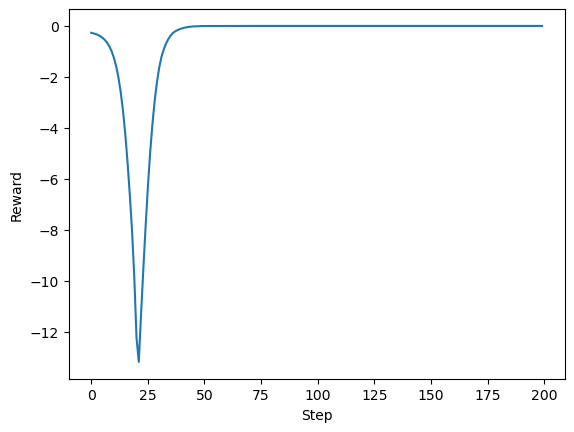

In [5]:
# 绘制奖励曲线
%matplotlib inline
plt.plot(rewards_history[1])
plt.xlabel('Step')
plt.ylabel('Reward')
plt.show()